In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Admission_Predict.csv')
df.head()

'''
The parameters included are : 
1. GRE Scores ( out of 340 ) 
2. TOEFL Scores ( out of 120 ) 
3. University Rating ( out of 5 ) 
4. Statement of Purpose and Letter of Recommendation Strength ( out of 5 ) 
5. Undergraduate GPA ( out of 10 ) 
6. Research Experience ( either 0 or 1 ) 
7. Chance of Admit ( ranging from 0 to 1 )
'''

'\nThe parameters included are : \n1. GRE Scores ( out of 340 ) \n2. TOEFL Scores ( out of 120 ) \n3. University Rating ( out of 5 ) \n4. Statement of Purpose and Letter of Recommendation Strength ( out of 5 ) \n5. Undergraduate GPA ( out of 10 ) \n6. Research Experience ( either 0 or 1 ) \n7. Chance of Admit ( ranging from 0 to 1 )\n'

In [3]:
df = df.drop('Serial No.', axis=1)

In [4]:
#drop negative rows
for col in df.columns:
    df = (df[df[col] >= 0])

df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [5]:
#check for NaN values
print(df.isnull().any())

GRE Score            False
TOEFL Score          False
University Rating    False
SOP                  False
LOR                  False
CGPA                 False
Research             False
Chance of Admit      False
dtype: bool


In [6]:
df_y = df['Chance of Admit']

df_x = df.loc[:, df.columns != 'Chance of Admit']
df_x.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,337,118,4,4.5,4.5,9.65,1
1,324,107,4,4.0,4.5,8.87,1
2,316,104,3,3.0,3.5,8.00,1
3,322,110,3,3.5,2.5,8.67,1
4,314,103,2,2.0,3.0,8.21,0


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import time

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, random_state = 1)
linReg = LinearRegression()
start = time.time()
linReg.fit(x_train, y_train)
end= time.time()
speed = end - start
print("time taken", speed)

#get coefficient and constant
print('intercept:', linReg.intercept_)
print('coefficient:', linReg.coef_)




time taken 0.008938789367675781
intercept: -1.1134215918214636
coefficient: [ 0.00142101  0.00285389  0.00789659 -0.00257597  0.02084557  0.11401394
  0.02857746]


In [8]:
y_hat = linReg.predict(x_test)
print("y hat:", y_hat[0:10])
print("y_test:", y_test.values[0:10])

from sklearn.metrics import mean_squared_error, r2_score as rsquare
print("rsquare:", rsquare(y_test, y_hat))
print("mean_squared_error:", mean_squared_error(y_test, y_hat))

y hat: [0.72298322 0.69528358 0.78934352 0.78213989 0.85310709 0.64473573
 0.63823164 0.5548887  0.49554919 0.93182171]
y_test: [0.67 0.64 0.8  0.81 0.86 0.58 0.73 0.56 0.54 0.94]
rsquare: 0.8163951846360177
mean_squared_error: 0.004183757026495225


In [9]:
#cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)


def generate_cross_val(model, x, y, kfold):
    score = cross_val_score(model, df_x, df_y, cv=k_fold)
    mean_score = round(np.mean(score)*100, 2)
    return (score, mean_score)

score, mean_score = generate_cross_val(linReg, df_x, df_y, k_fold)
print(score)
print(mean_score)

[0.72692178 0.74194935 0.76201541 0.71779624 0.86463423 0.85477452
 0.74815227 0.80415608 0.89387166 0.75269381]
78.67


In [10]:
#feature reduction
df.corr()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
GRE Score,1.000000,0.835977,0.668976,0.612831,0.557555,0.833060,0.580391,0.802610
TOEFL Score,0.835977,1.000000,0.695590,0.657981,0.567721,0.828417,0.489858,0.791594
University Rating,0.668976,0.695590,1.000000,0.734523,0.660123,0.746479,0.447783,0.711250
SOP,0.612831,0.657981,0.734523,1.000000,0.729593,0.718144,0.444029,0.675732
LOR,0.557555,0.567721,0.660123,0.729593,1.000000,0.670211,0.396859,0.669889
CGPA,0.833060,0.828417,0.746479,0.718144,0.670211,1.000000,0.521654,0.873289
Research,0.580391,0.489858,0.447783,0.444029,0.396859,0.521654,1.000000,0.553202
Chance of Admit,0.802610,0.791594,0.711250,0.675732,0.669889,0.873289,0.553202,1.000000


In [11]:
from sklearn.decomposition import PCA

#the scores columns are highly interlinked
#try 2 principal components - combined scores, University Rating
#drop research

x = df_x.to_numpy()
pca = PCA(n_components = 4)

from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(x)

principalComponents = pca.fit_transform(X_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc 1', 'pc 2', 'pc 3', 'pc 4'])

finalDf = pd.concat([principalDf, df_y], axis = 1)
finalDf.head(5)

,pc 1,pc 2,pc 3,pc 4,Chance of Admit
0,-3.543521,-0.324142,-0.531108,-0.566630,0.92
1,-1.631253,0.078057,0.890164,-0.107396,0.76
2,0.570107,-0.681066,0.999627,0.090603,0.72
3,-0.296114,-1.303278,-0.245057,0.510124,0.80
4,2.061638,0.036091,-0.663555,-0.564435,0.65


In [12]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.69614538 0.10355405 0.07809881 0.04427205]
0.9220702943014075


In [18]:
new_df_x = finalDf.loc[:, finalDf.columns != 'Chance of Admit']
new_df_y = finalDf['Chance of Admit']
new_linReg = LinearRegression()

x_train, x_test, y_train, y_test = train_test_split(new_df_x, new_df_y, random_state = 1)

start = time.time()
new_linReg.fit(x_train, y_train)
end= time.time()
speed = end - start
print("time taken", speed)


print('intercept:', new_linReg.intercept_)
print('coefficient:', new_linReg.coef_)


y_hat = new_linReg.predict(x_test)
print("rsquare:", rsquare(y_test, y_hat))
print("mean_squared_error:", mean_squared_error(y_test, y_hat))

time taken 0.0029914379119873047
intercept: 0.7269760837471921
coefficient: [-0.05510072 -0.00957575 -0.01248797 -0.0193507 ]
rsquare: 0.797640786130215
mean_squared_error: 0.004611108816647323


In [14]:
new_score, new_mean_score = generate_cross_val(new_linReg, new_df_x, new_df_y, k_fold)
print(new_score)
print(new_mean_score)

[0.72692178 0.74194935 0.76201541 0.71779624 0.86463423 0.85477452
 0.74815227 0.80415608 0.89387166 0.75269381]
78.67


In [15]:
#the r-square score from cross validation has reduced
#Therefore, this proves that Research has no effect, and that the scores can be lumped together

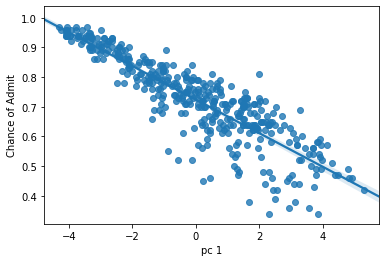

In [16]:
import seaborn as sns
sns.regplot(x= 'pc 1', y = 'Chance of Admit', data = finalDf)

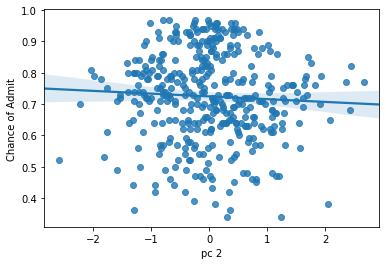

In [17]:
import seaborn as sns2
sns2.regplot(x= 'pc 2', y = 'Chance of Admit', data = finalDf)